### Contents

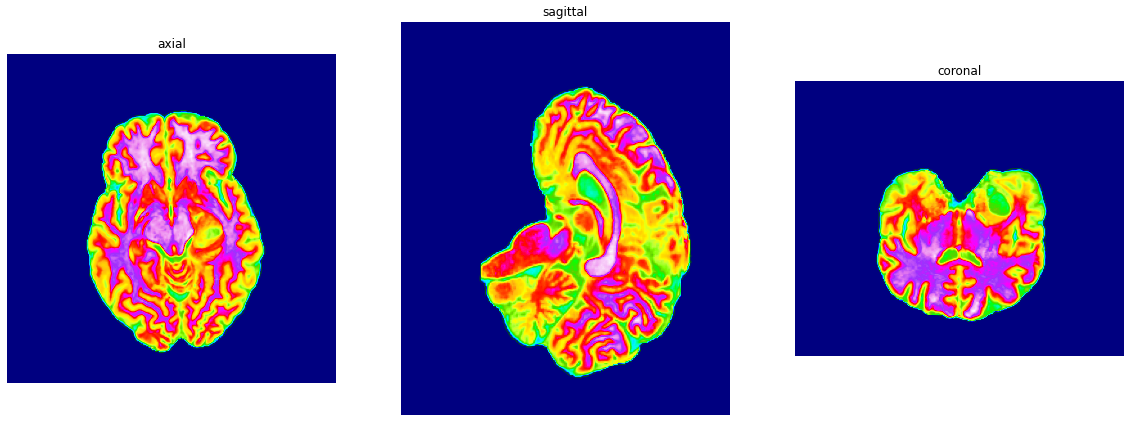

- Load dependancies - .. Done!
- Explore Data - .. Done!
    - Basic EDA
    - Extract best image from each of the structural multi-parametric MRI (mpMRI) scans
    - Convert that image to PNG and use for training
- DataBlock - .. Done!
- Training - .. Done!
- Submission - .. Done!


### Model

Extract the best image based on dicom window width and center from each of the structural multi_parametric MRI scans, save that image into PNG and use a pretrained [timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm) model `ig_resnext101_32x16d`.  Inference involves extracting the best image (again based on dicom window width and center) and averaging the prediction across all structural multi_parametric scans.

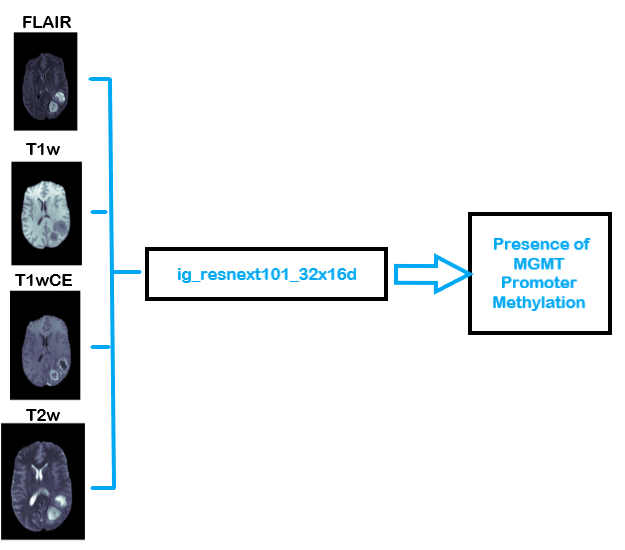

## Load Dependancies

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

This notebook uses various functions from the [fmi](https://github.com/asvcode/fmi) library which is a package that adds additional functionality to [fastai's](https://www.fast.ai/) medical imaging module. 

To learn more about medical imaging view my [blog](https://asvcode.github.io/MedicalImaging/)


The `fmi` library can be easily cloned (**with internet ON**):

In [ ]:
#!git clone https://github.com/asvcode/fmi.git

Since internet is off in this case you can use the [fmipackage](https://www.kaggle.com/avirdee/fmipackage) dataset

In [ ]:
!cp -r ../input/fmipackage/fmi-master/* ./

In [ ]:
from fmi.explore import *
from fmi.preprocessing import *
from fmi.pipeline import *

Load `timm`

In [ ]:
!pip install '../input/timm034/timm-0.3.4-py3-none-any.whl' -qq

In [ ]:
from fastai.vision.all import *
from fastai.medical.imaging import *
import pydicom
from torchvision.utils import save_image
from glob import glob
from skimage import exposure
from pydicom.pixel_data_handlers.util import apply_voi_lut

from timm import create_model
from fastai.vision.learner import _update_first_layer
matplotlib.rcParams['image.cmap'] = 'gist_ncar'

You can easily review your system info using system_info

In [ ]:
system_info()

Load the data

In [ ]:
source = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
train_files = get_dicom_files(f'{source}/train/00000')
train_path = f'{source}/train'
labels = pd.read_csv(f'{source}/train_labels.csv', header=0, names=['id','value'], dtype=object)
print(os.listdir(source))

In [ ]:
labels[:5]

[fmi](https://github.com/asvcode/fmi) has a number of handy features that breakdown the metadata into useful chunks. Firstly you may want to quickly see what image information is contained in the metadata. You can access this using get_image_info

In [ ]:
get_image_info(train_files[7])

Check to see if there is any personally identifiable data in the metadata

In [ ]:
get_pii(train_files[7])

There does not seem to be any personally identifiable data.

## Explore Data

### Basic EDA

Each dedicated folder is identified by a five-digit number which is further broken down into 4 subfolders:

- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)

Using folder `00000` as an example

In [ ]:
source_00000 = f'{source}/train/00000/'
print(os.listdir(source_00000))

You could view the images within the `T2w` folder like this:

In [ ]:
sort_items = get_dicom_files(source_00000, folders='T2w')

In [ ]:
imgs = []
for filename in sort_items:
    file = filename.dcmread().pixel_array
    img = TensorDicom(file)
    imgs.append(img)
show_images(imgs, nrows=12)

Although this displays the images within the folder they are not displayed in sequence. [fmi](https://github.com/asvcode/fmi) provides a handy function that easily sorts the images by `instance number`

In [ ]:
instance_show(sort_items, nrows=20)

MRI scans are made up of numerous 2D slices taken from a number of angles(or planes). The 3 planes are axial, sagittal and cornonal and the image below show what angels the planes represent. [Image credit](https://www.ipfradiologyrounds.com/hrct-primer/image-reconstruction/)

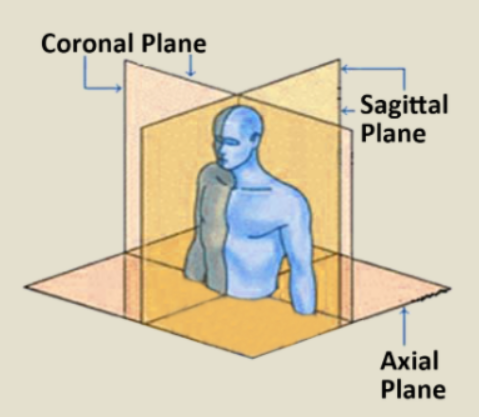

`show_aspects` is a handy function that easily lets you view the various planes.

**Fluid Attenuated Inversion Recovery (FLAIR)**

In [ ]:
FLAIR_00000 = f'{source_00000}/FLAIR'
show_aspects(FLAIR_00000, show=True, save=False, figsize=(17,12))

You can also easily extract the metadata from the dicom images using `from_dicoms`

In [ ]:
flair_00000_files = get_dicom_files(FLAIR_00000)

In [ ]:
dicom_dataframe = pd.DataFrame.from_dicoms(flair_00000_files, window=dicom_windows.brain, px_summ=True)
dicom_dataframe[:10]

`get_dicom_image` is another handy feature that lets you view images within a dataframe and sort them by various items such as `img_pct_window`, `img_mean` or `img_std`.

We will use this later in extracting the best images from each of the folders.

In [ ]:
def get_dicom_image(df, key, nrows=1, source=None, folder_val=None, instance_val=None, figsize=(7,7)):
    "Helper to view images by key"
    imgs=[]
    title=[]
    for i in df.index:
        file_path = Path(f"{df.iloc[i]['fname']}")
        dcc = file_path.dcmread().pixel_array
        imgs.append(dcc)
        pct = df.iloc[i][key]
        title.append(pct)
    return show_images(imgs, titles=title, nrows=nrows)

**sort by `img_pct_window`**

In [ ]:
pct = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_pct_window'], ascending=False).reset_index(drop=True)
get_dicom_image(pct[:10], 'img_pct_window', source=source, nrows=1, figsize=(20,20))

**sort by `img_mean`**

In [ ]:
pct = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_mean'], ascending=False).reset_index(drop=True)
get_dicom_image(pct[:10], 'img_mean', source=source, nrows=1, figsize=(20,20))

**sort by `img_std`**

In [ ]:
pct = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_std'], ascending=False).reset_index(drop=True)
get_dicom_image(pct[:10], 'img_std', source=source, nrows=1, figsize=(20,20))

### Extract best image from each of the structural multi-parametric MRI (mpMRI) scans

In order to iterate quickly and get some baseline results the aim is to get the best images from each folder.  In order to do this:
 - we will extract the dicom metadata from each sub folder
 - sort the metadata based on dicom window width and center
 - Create a mask based on the dicom window width and center and get rid of unwanted pixels
 - Save the image that best matches our criteria by converting it into PNG format
 - Create a dataframe with columns that contain the `path` to that image (we will need this when constructing the `DataBlock`)

Note that the `cmap` color used above is purely for aesthetics reasons and actually does not have any impact from a training perspective.  However moving forward we change it to a more appropriate color map

In [ ]:
matplotlib.rcParams['image.cmap'] = 'bone'

`process_dicom` is a handy `fmi` function that crops a dicom image (dependant on dicom window, sigma and thresh values) and saves it in .png format. You have to specify the outpath (where the .png files will be stored), the window width and center, sigma and thresh values.  By default displaying the differences in the images and sanity check is set to `False`

In [ ]:
outpath = './test1.png'
window = dicom_windows.brain_soft
sigma = 0.1
thresh = 0.7
remove_max = False

Have a test run with the first 5 independant cases and using the `T1wCE` folder, we create a dicom dataframe using a `brain_soft` dicom window for each case in the `T1wCE` folder, sort it by `img_pct_window` (img_pct_window is a handy `fastai` function that displays the percentage of pixels within a specified dicom window in an image), and then use `process_dicom` to save the image.

This is how I created the datasets for each of the structural multi_parametric scans.  To generate the correct paths to save the images I used the code below, which also solves for duplicate file names across the independant cases

In [ ]:
def get_outpath(input_dir, dataset):
    img_id = input_dir.split('-')[-1].split('.')[0]
    outpath = os.path.join(f'./{dataset}',f'{img_id}.png')
    
    check = os.path.isfile(outpath)
    if check is not True:
        process_dicom(input_dir, outpath, window=dicom_windows.brain_soft, sigma=0.1, thresh=0.7, remove_max=False, show=True, sanity=True)
    else:
        i = 0
        while True:
            outpath = os.path.join(f'./{dataset}',f'{img_id}_{i}.png')
            if not os.path.exists(outpath):
                process_dicom(input_dir, outpath, window=dicom_windows.brain_soft, sigma=0.1, thresh=0.7, remove_max=False, show=True, sanity=True)
                break
            i += 1    
    return outpath

create the folder where you will saving the files

In [ ]:
if not os.path.exists('./train'):
    os.makedirs('./train')

We also have to save the image names and file paths so that we can use it in training later

In [ ]:
fpath = []
for file in labels['id'][:5]:
    path = f'{train_path}/{file}/T1wCE/'
    files = get_dicom_files(path)
    dicom_dataframe = pd.DataFrame.from_dicoms(files, window=dicom_windows.brain_soft, px_summ=True)
    pct = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_pct_window'], ascending=True).reset_index(drop=True)
    ff = pct['fname'][0]
    outfile = get_outpath(ff, 'train')
    fpath.append(outfile)

Save the filepaths

In [ ]:
labels5 = labels[:5]
labels5['path'] = pd.Series(fpath).values
labels5

## DataBlock

Create the `datablock`, one for each type of scan

In [ ]:
flair_source = '../input/rsna-miccai'
t1w_source = '../input/t1w-one'
t1wce_source = '../input/t1wce-one'
t2w_source = '../input/t2w-one'
df = pd.read_csv(f'{source}/train_labels.csv')
df_rs = pd.read_csv(f'{flair_source}/train_Fcrop_one.csv')
df_t1w = pd.read_csv(f'{t1w_source}/T1w_brain_soft.csv')
df_1wce = pd.read_csv(f'{t1wce_source}/T1wCE_brain_soft.csv')
df_t2w = pd.read_csv(f'{t2w_source}/T2w_brain_soft.csv')

Function to extract the file name

In [ ]:
def get_one(f):
    one = f.split('/')[-1]
    return one

Correct the path names for each image

In [ ]:
df_rs['path'] = df_rs['path'].apply(lambda x: f'../input/rsna-miccai/train_crop_FLAIR/{get_one(x)}')
df_t1w['path'] = df_t1w['path'].apply(lambda x: f'../input/t1w-one/train/{get_one(x)}')
df_1wce['path'] = df_1wce['path'].apply(lambda x: f'../input/t1wce-one/train/{get_one(x)}')
df_t2w['path'] = df_t2w['path'].apply(lambda x: f'../input/t2w-one/train/{get_one(x)}')

Merge all into  one dataframe

In [ ]:
df_rs['t1w_path']= df_t1w['path']
df_rs['t1wce_path'] = df_1wce['path']
df_rs['t2w_path'] = df_t2w['path']
df_rs

We now have the dataframe we can use in consturcting the `DataBlock`

Specify some transforms

In [ ]:
batch_tfms = [Resize(224), *aug_transforms(do_flip=False, 
                                           flip_vert=False, 
                                           max_rotate=27,  
                                           min_zoom=1.,
                                           max_zoom=1.,
                                           max_lighting=0.1), Normalize.from_stats(*imagenet_stats)]

Specify the blocks, note that `n_inp` is set to 4 because there will be 4 inputs

In [ ]:
blocks = (
          ImageBlock(cls=PILImage),
          ImageBlock(cls=PILImage),
          ImageBlock(cls=PILImage),
          ImageBlock(cls=PILImage),
          CategoryBlock)

getters = [
           ColReader('path'),
           ColReader('t1w_path'),
           ColReader('t1wce_path'),
           ColReader('t2w_path'),
           ColReader('value'),
          ]

miccai = DataBlock(blocks=blocks,
              getters=getters,
              item_tfms=Resize(196),
              n_inp=4
              )

dls = miccai.dataloaders(df_rs, bs=16)

## Training

Because we have 4 inputs we will have to alter the model so that it can accommodate the inputs (this is adapted from [here](https://docs.fast.ai/tutorial.siamese.html))

In [ ]:
class MiccaiModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head

    def forward(self, x1, x2, x3, x4):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2), self.encoder(x3), self.encoder(x4)], dim=1)
        return self.head(ftrs)

Specify the splitter

In [ ]:
def miccai_splitter(model):
    return [params(model.encoder), params(model.head)]

In order to be able to use `timm` models the following is credited from [here](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_EfficientNet_and_Custom_Weights.ipynb)

In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [ ]:
os.makedirs('/root/.cache/torch/hub/checkpoints/')

!cp '../input/rsna-miccai/ig_resnext101_32x16-c6f796b0.pth' '/root/.cache/torch/hub/checkpoints/ig_resnext101_32x16-c6f796b0.pth'
#!cp '../input/rsna-miccai/semi_supervised_resnext101_32x16-15fffa57.pth' '/root/.cache/hub/checkpoints/semi_supervised_resnext101_32x16-15fffa57.pth'

In [ ]:
body = create_timm_body('ig_resnext101_32x16d', pretrained=True)
head = create_head(2048*4, 2, ps=0.5)
model = MiccaiModel(body, head)

In [ ]:
learn = Learner(dls,
                model,
                loss_func = LabelSmoothingCrossEntropy(),
                metrics = accuracy,
                cbs=[ShowGraphCallback(),\
                    SaveModelCallback(monitor='accuracy',fname='best_accuracy',comp=np.greater, with_opt=True)])

learn.to_fp16()

In [ ]:
learn.fit_one_cycle(27, 1e-3)

## Submission

Load the model with the best accuracy

In [ ]:
learn.load('best_accuracy')

For the `test` set we will be doing the same as we did for the `train` set ie grab the best images within each test case folder and across each structural multi_parametric scan and save the file in .png format for inference.

In [ ]:
test_set = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/test'

if not os.path.exists('./test'):
    os.makedirs('./test')

In [ ]:
df_test = pd.DataFrame(columns=['id', 'value'])
df_test.id = os.listdir("../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/")
df_test[:5]

In [ ]:
def get_png(t):
    f = t.split('/')
    folderp = f'test/{f[-3]}/{f[-2]}'
    filep = f'{folderp}/{f[-1]}'
    fff = filep.split('.')[0]
    outpath = f'{fff}.png'
    
    dicom = pydicom.read_file(t)
    data = apply_voi_lut(dicom.pixel_array, dicom)
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    height = len(data)
    width = len(data[0])
    
    pixels_out = []
    for row in data:
        pixels_out.extend(row)
    assert(len(pixels_out) == height * width)
    image_out = Image.new('L', (width, height))
    image_out.putdata(pixels_out)

    if not os.path.exists(folderp):
        os.makedirs(folderp)
    image_out.save(outpath)
    
    return outpath, image_out

Get the probabilities

In [ ]:
probs_one = []
for file in df_test['id']:
    ## fLAIR
    path = f'{test_set}/{file}/FLAIR/'
    g = get_dicom_files(path)
    dicom_dataframe = pd.DataFrame.from_dicoms(g, window=dicom_windows.brain_soft, px_summ=True)
    pct = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_pct_window'], ascending=True).reset_index(drop=True)
    ff = pct['fname'][0]
    png_file, image1 = get_png(ff)
    print(png_file)
    
    #T1W
    tpath = f'{test_set}/{file}/T1w/'
    t = get_dicom_files(tpath)
    dicom_dataframe2 = pd.DataFrame.from_dicoms(t, window=dicom_windows.brain_soft, px_summ=True)
    pct2 = dicom_dataframe2[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_pct_window'], ascending=True).reset_index(drop=True)
    fff = pct2['fname'][0]
    png_file2, image2 = get_png(fff)
    print(png_file2)
    
    #T1WCE
    wpath = f'{test_set}/{file}/T1wCE/'
    w = get_dicom_files(wpath)
    dicom_dataframe3 = pd.DataFrame.from_dicoms(w, window=dicom_windows.brain_soft, px_summ=True)
    pct3 = dicom_dataframe3[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_pct_window'], ascending=True).reset_index(drop=True)
    ffff = pct3['fname'][0]
    png_file3, image3 = get_png(ffff)
    print(png_file3)
    
    #T2W
    rpath = f'{test_set}/{file}/T2w/'
    q = get_dicom_files(rpath)
    dicom_dataframe4 = pd.DataFrame.from_dicoms(q, window=dicom_windows.brain_soft, px_summ=True)
    pct4 = dicom_dataframe4[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std', 'fname']].sort_values(by=['img_pct_window'], ascending=True).reset_index(drop=True)
    fff3 = pct4['fname'][0]
    png_file4, image4 = get_png(fff3)
    print(png_file4)
    
    test_dl = learn.dls.test_dl([png_file, png_file2, png_file3, png_file4])
    preds, probs2 = learn.tta(dl=test_dl, n=1)
    print(preds, probs2)
    show_images([image1, image2, image3, image4], titles=preds)
    
    value_0 = []
    value_1 = []
    for p in preds:
        value_0.append(p[0].item())
        value_1.append(p[1].item())
    val0_final = sum(value_0)/4
    val1_final = sum(value_1)/4
    fin = [val0_final, val1_final]
    print(max(fin))
    probs_one.append(max(fin))

In [ ]:
df_test['value'] = pd.Series(probs_one).values

In [ ]:
df_test.rename(columns={'id':'BraTS21ID','value':'MGMT_value'}, inplace=True)
df_test

In [ ]:
df_test.to_csv('submission.csv', index=False)